# I. Importing required libraries.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [3]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import scikitplot as skplt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import itertools
import string
import re
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import multiprocessing
cores = multiprocessing.cpu_count()
cores

2

In [4]:
#An overview of the data at hand.
columns = ["target", "ids", "date", "flag", "user", "text"]
data = pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names=columns)
data

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


# II. Text PreProcessing

In [5]:
#Checking for any missing values and relabelling the target variable.
print(data.isnull().sum())
print(data['target'].value_counts())
sentiment2label = {'Negative': 0, 'Neutral': 2, 'Positive': 4}
data.loc[data['target']==0, 'target'] = 'Negative'
data.loc[data['target']==2, 'target'] = 'Neutral'
data.loc[data['target']==4, 'target'] = 'Positive'
data.head()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64
4    800000
0    800000
Name: target, dtype: int64


,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#Removal of unnecessary stopwords. However, certain negative sentiment stopwords aren't removed as it may change the meaning of the text.
StopWords = set(stopwords.words('english')+['com'])
StopWords.remove('not')
StopWords.remove("hasn't")
StopWords.remove("hadn't")
StopWords.remove("couldn't")
StopWords.remove("mightn't")
StopWords.remove("wouldn't")
StopWords.remove("mustn't")
StopWords.remove('mightn')
StopWords.remove('shouldn')
StopWords.remove('isn')
StopWords.remove("isn't")
StopWords.remove("needn't")
StopWords.remove("shouldn't")
StopWords.remove("shan't")
StopWords.remove("weren't")
StopWords.remove('didn')
StopWords.remove('weren')
StopWords.remove('hasn')
StopWords.remove('doesn')
StopWords.remove("doesn't")
StopWords.remove("didn't")
StopWords.remove("don't")
StopWords.remove("won't")
StopWords.remove('ain')
StopWords.remove('mustn')
StopWords.remove('hadn')
StopWords.remove("aren't")
StopWords.remove('aren')
StopWords.remove('wasn')
StopWords.remove("haven't")
StopWords.remove('needn')
StopWords.remove('haven')
StopWords.remove('wouldn')
StopWords.remove("wasn't")
print(StopWords) #Remaining list of stopwords
def preprocess(text):
    text = ' '.join([word.lower() for word in text.split() if word.lower() not in StopWords])
    #Removing mentions, hyperlinks from tweets.
    text = ' '.join([word for word in text.split() if ('@' not in word and 'https' not in word and 'http' not in word)])
    #Removing punctuations.
    trans = str.maketrans('','',string.punctuation)
    text = text.translate(trans)
    return text


{'itself', "she's", 'theirs', 'i', 'which', 'then', 'its', 'now', 'my', 'whom', 'above', 'y', 'on', 'at', 'is', 'why', 'no', 'both', 'up', 'only', 'such', 'because', 'other', 'during', 're', 'your', 'own', 'after', 'into', "you'd", 'herself', 'in', 'all', 'doing', 'ourselves', 'be', 'the', 'his', 'are', 'if', 'her', 'did', 'over', 'there', 'when', 'under', 'those', 'or', 'very', 'what', 'how', 'each', 'few', 'am', "should've", 'them', "you'll", 'him', 'their', 'he', 'don', 'we', 'myself', 'ours', 'can', 'than', 'will', 'who', 't', "you've", 'further', 'yours', 'being', 'from', 'couldn', 'where', 'had', 'some', 'about', 'won', 'below', 'but', 'they', 'should', 'so', 'just', 'me', 'more', 'it', 'down', 'as', 'ma', 'd', 'this', 'she', 'again', 'too', 'through', 'same', 'and', 'for', 'com', 'most', "you're", 'once', "it's", 'while', 'our', 's', 'you', 'with', 'hers', 'to', 'these', 'been', 'between', 'm', 'were', 'off', 'that', 'themselves', 've', 'any', 'here', 'himself', 'do', 'an', 'has

In [7]:
#Cleaned data
data['text'] = data['text'].apply(preprocess)
data.head()

,target,ids,date,flag,user,text
0,Negative,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda got david carr thir...
1,Negative,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,Negative,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest go ...
3,Negative,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire
4,Negative,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,no not behaving all im mad here cant see there


In [8]:
#Lemmatization of Data: Tracing words back to their root word in English, as it brings down vocabulary size and reduces verbosity, without altering the meaning.
X = data['text'].tolist()
lemmatizer = WordNetLemmatizer()
def lemmatize(corpus):
    lem_corpus = []
    for text in X:
        lem_text = ''
        for word in text.split():
            word = re.sub('#','',word) #Removing # from the hashtags
            lem_word = lemmatizer.lemmatize(word) #For nouns
            lem_word = lemmatizer.lemmatize(lem_word, pos='v') #For verbs
            lem_text = lem_text + ' ' + lem_word
        lem_corpus.append(lem_text)
    return lem_corpus

X_lem = lemmatize(X)
print(X_lem[:10])

#Transforming the categorical output variable into numerical (0,1,2) labels
Label_Encoder = LabelEncoder()
y = Label_Encoder.fit_transform(data['target'])

[' awww thats bummer shoulda get david carr third day it d', ' upset cant update facebook texting it might cry result school today also blah', ' dive many time ball manage save 50 rest go bind', ' whole body feel itchy like fire', ' no not behave all im mad here cant see there', ' not whole crew', ' need hug', ' hey long time see yes rain bite only bite lol im fine thank hows', ' nope didnt', ' que muera']


# III. Basic EDA

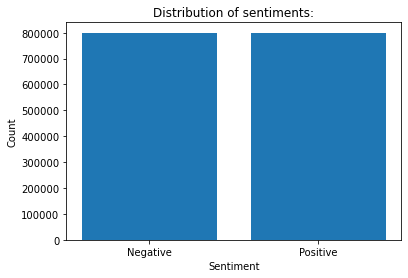

In [9]:
#Distribution of Sentiments
plt.bar(Counter(data.target).keys(), Counter(data.target).values())
plt.title('Distribution of sentiments:')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [10]:
#Count of various n-gram tokens
X_lem_pos = []
X_lem_neg = []
for idx in range(len(y)):
    if y[idx]==1:
        X_lem_pos.append(X_lem[idx])
    else:
        X_lem_neg.append(X_lem[idx])
#Decreasing order of 1-gram tokens in positive tweets        
count_vect = CountVectorizer(ngram_range=(1,1), stop_words=StopWords)
count_pos = count_vect.fit_transform(X_lem_pos)
df1 = pd.DataFrame(count_pos.sum(axis=0), columns=count_vect.get_feature_names()).T.sort_values(0, ascending=False).head(50)

#Decreasing order of uni-gram & bi-gram tokens in negative tweets
count_vect = CountVectorizer(ngram_range=(1,2), stop_words=StopWords)
count_neg = count_vect.fit_transform(X_lem_neg)
df2 = pd.DataFrame(count_neg.sum(axis=0), columns=count_vect.get_feature_names()).T.sort_values(0, ascending=False).head(50)

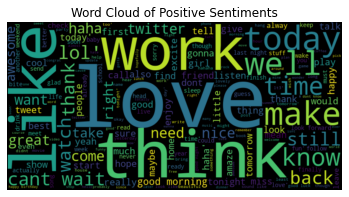

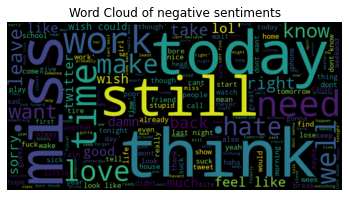

In [11]:
#Wordcloud, a very popular EDA technique for text data. Done separately for positive and negative tweets
wordcloud = WordCloud(min_word_length=4, stopwords=StopWords, width=800, height=400, min_font_size=6)
wordcloud.generate(str(X_lem_pos))
plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Word Cloud of Positive Sentiments')
plt.show()

wordcloud.generate(str(X_lem_neg))
plt.axis("off")
plt.title('Word Cloud of negative sentiments')
plt.imshow(wordcloud, interpolation="bilinear")
plt.show()

# IV. Preparing Data For Training

In [12]:
#Train-test split of dataset
X_train, X_test, y_train, y_test = train_test_split(X_lem, y, test_size=0.02)
print('Size of training data:', len(X_train))
print('Size of testing data:', len(X_test))

#Get the maximum token length of each sentence
sent_list = []
for text in X_train:
    tokens = []
    for word in text.split():
        tokens.append(word)
    sent_list.append(tokens)

max_len=0
for token_list in sent_list:
    if len(token_list)>max_len:
        max_len = len(token_list)
print('max length of input text:',max_len)

Size of training data: 1568000
Size of testing data: 32000
max length of input text: 37


In [12]:
#Training word embeddings using Word2Vec in gensim module
embedding_dim=300 #Dimension of embedding vectors of each word
w2vmodel = Word2Vec(min_count=2, window=7, workers=cores-1, size=embedding_dim)
w2vmodel.build_vocab(sent_list)

w2vmodel.train(sent_list, total_examples=len(sent_list), epochs=32)
print('No. of word embeddings trained:',len(w2vmodel.wv.vocab))

No. of word embeddings trained: 121351


In [13]:
#Check similarity scores of words most similar to certain word. 
#Cosine Similarity score is calculated as the cosine of angle between embedding vectors of 2 words
w2vmodel.most_similar('hello')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('hi', 0.6566270589828491),
 ('welcome', 0.4851013720035553),
 ('hey', 0.4721652865409851),
 ('howdy', 0.4634217619895935),
 ('hellooo', 0.43421670794487),
 ('hola', 0.4284239411354065),
 ('quothiquot', 0.4256421625614166),
 ('goodmorning', 0.41370654106140137),
 ('hiya', 0.4105850160121918),
 ('helloo', 0.3940010964870453)]

In [14]:
#Keras Tokenizer: generates index labels for each word in vocabulary, which is stored in the word_index dict.
#Padding is applied to append zeroes to shorter sequences, since all texts may not be of same length. Here, pre-padding is done.
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1 
train_seq = tokenizer.texts_to_sequences(X_train)
train_pad = pad_sequences(train_seq, maxlen=max_len)
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = pad_sequences(test_seq, maxlen=max_len)

In [15]:
#Generate TF-IDF matrix including features from uni-, bi-, tri- gram tokens.
Tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=0.7)
X_train_tfidf = Tfidf.fit_transform(X_train)
X_test_tfidf = Tfidf.transform(X_test)

In [16]:
#Train basic Logistic Classifier and cross-validate for regularization parameter
param_grid = {'C':[0.01,0.1,1,10,100]}
clf = LogisticRegression(max_iter=10000)
grid = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=len(param_grid.values()))
cv_result = grid.fit(X_train_tfidf, y_train)
print(cv_result.cv_results_)
print(cv_result.best_params_)
best_clf = cv_result.best_estimator_

{'mean_fit_time': array([780.22170124]), 'std_fit_time': array([50.67950291]), 'mean_score_time': array([0.05065145]), 'std_score_time': array([0.00759835]), 'param_C': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'C': 100}], 'split0_test_score': array([0.75989477]), 'split1_test_score': array([0.76046875]), 'split2_test_score': array([0.76028699]), 'split3_test_score': array([0.7607111]), 'split4_test_score': array([0.76066008]), 'mean_test_score': array([0.76040434]), 'std_test_score': array([0.00029566]), 'rank_test_score': array([1], dtype=int32)}
{'C': 100}


Accuracy with logistic Regression: 0.77575
Area under ROC curve with logistic classifier: 0.8522784185086234


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


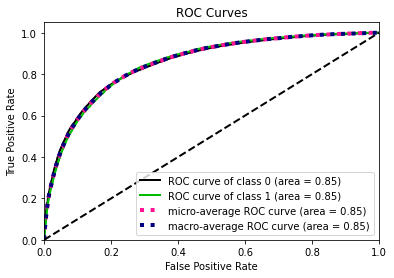

In [17]:
#Training the classifier with optimized hyperparameter
best_clf.fit(X_train_tfidf, y_train)
y_pred = best_clf.predict(X_test_tfidf)
print('Accuracy with logistic Regression:',accuracy_score(y_test, y_pred)) #Accuracy score
y_prob = best_clf.predict_proba(X_test_tfidf)
y_pos = [prob[1] for prob in y_prob]
print('Area under ROC curve with logistic classifier:',roc_auc_score(y_test, y_pos)) #ROC score: preferably closer to 1.
skplt.metrics.plot_roc_curve(y_test, y_prob)
plt.show()

[[0.76498561 0.23501439]
 [0.2135098  0.7864902 ]]


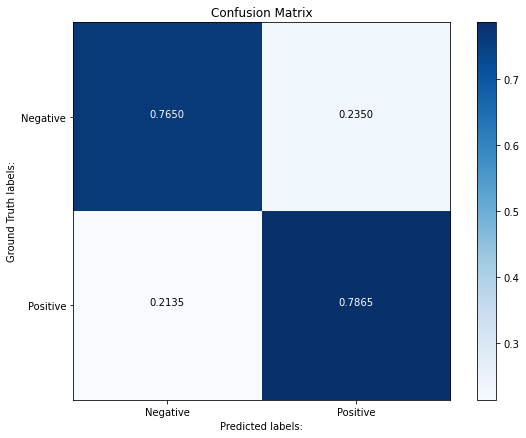

In [18]:
#Plotting confusion matrix for TP,FP,TN,FN
cm = confusion_matrix(y_test, y_pred, normalize='true')

def plot_confusion_matrix(cm, normalize, cmap, label_names, title):
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    if label_names is not None:
        ticks = np.arange(len(label_names))
        plt.xticks(ticks, label_names)
        plt.yticks(ticks, label_names)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            
    plt.tight_layout()
    plt.xlabel('Predicted labels:')
    plt.ylabel('Ground Truth labels:')
    
print(cm)
plot_confusion_matrix(cm, normalize=True, cmap=None, label_names=['Negative', 'Positive'], title='Confusion Matrix')

In [21]:
#Creating embedding matrix using generated word emeddings. Null vector used for words whose vectors could not be trained using Word2Vec
embedding_dim=300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, idx in tokenizer.word_index.items():
    if word in w2vmodel.wv:
        embedding_matrix[idx] = w2vmodel.wv[word]
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24599089,  0.02650384, -1.04180086, ...,  2.56603813,
         0.17544146,  0.91405392],
       [ 0.18349427,  1.15773654, -0.46684545, ...,  1.04047465,
        -0.85314608, -0.55275708],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#Randomized Search Cross-Validation for Neural Network hyperparameters.
def create_model(nn1=64, hidden=300, lr=0.001):
    model=keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(keras.layers.SpatialDropout1D(0.2))
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(nn1, return_sequences=True)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(hidden, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=create_model, epochs=30)
param_grid = dict(nn1=[32,64,128], hidden=[150,200,250,300], lr=[0.01,0.001], batch_size=[128,256,512])
CV_grid = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, cv=3)
cv_result = CV_grid.fit(train_pad, y_train)


Epoch 1/30
8167/8167 [==============================] - 133s 16ms/step - loss: 0.4800 - accuracy: 0.7700
Epoch 2/30
8167/8167 [==============================] - 131s 16ms/step - loss: 0.4823 - accuracy: 0.7684
Epoch 3/30
8167/8167 [==============================] - 130s 16ms/step - loss: 0.4858 - accuracy: 0.7662
Epoch 4/30
8167/8167 [==============================] - 132s 16ms/step - loss: 0.4879 - accuracy: 0.7648
Epoch 5/30
8167/8167 [==============================] - 130s 16ms/step - loss: 0.4861 - accuracy: 0.7659
Epoch 6/30
8167/8167 [==============================] - 130s 16ms/step - loss: 0.4860 - accuracy: 0.7658
Epoch 7/30
8167/8167 [==============================] - 129s 16ms/step - loss: 0.4876 - accuracy: 0.7652
Epoch 8/30
8167/8167 [==============================] - 128s 16ms/step - loss: 0.4860 - accuracy: 0.7660
Epoch 9/30
8167/8167 [==============================] - 129s 16ms/step - loss: 0.4860 - accuracy: 0.7662
Epoch 10/30
8167/8167 [==============================] 

8167/8167 [==============================] - 136s 17ms/step - loss: 0.4854 - accuracy: 0.7667
Epoch 17/30
8167/8167 [==============================] - 135s 17ms/step - loss: 0.4849 - accuracy: 0.7666
Epoch 18/30
8167/8167 [==============================] - 134s 16ms/step - loss: 0.4844 - accuracy: 0.7673
Epoch 19/30
8167/8167 [==============================] - 130s 16ms/step - loss: 0.4852 - accuracy: 0.7672
Epoch 20/30
8167/8167 [==============================] - 132s 16ms/step - loss: 0.4866 - accuracy: 0.7662
Epoch 21/30
8167/8167 [==============================] - 129s 16ms/step - loss: 0.4890 - accuracy: 0.7637
Epoch 22/30
8167/8167 [==============================] - 132s 16ms/step - loss: 0.4882 - accuracy: 0.7648
Epoch 23/30
8167/8167 [==============================] - 135s 17ms/step - loss: 0.4871 - accuracy: 0.7654
Epoch 24/30
8167/8167 [==============================] - 136s 17ms/step - loss: 0.4860 - accuracy: 0.7657
Epoch 25/30
8167/8167 [==============================] - 1

In [ ]:
print(cv_result.cv_results_)
print(cv_result.best_params_)

In [ ]:
#RNN Model using Bi-LSTM Cells and Word2Vec trained embedding vectors. No need to train the embedding layer again.
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False),
    keras.layers.SpatialDropout1D(0.2),
    keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
    keras.layers.BatchNormalization(),
    keras.layers.Bidirectional(keras.layers.LSTM(32)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(embedding_dim, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
print(model.summary())
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
history = model.fit(train_pad, y_train, batch_size=512, epochs=30, validation_data=(test_pad, y_test))